In [2]:
# ------------ System imports ------------
import os
import pandas
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import make_blobs
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import numpy as np

import os 
import sys
import datetime
import time
import argparse

# ------------ Scientific imports ------------
import pandas as pd
import seaborn as sns
import numpy as np

import sklearn as skl
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense


from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from keras.models import load_model
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
from numpy import argmax
from sklearn.feature_selection import SelectKBest,f_classif

In [11]:
# ------------ Stacking Framwework ------------
#Stacking method is inspired by the following resource: https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/


def stacking_pipeline(X_test, y_test,
	models = [],
	num_hidden_layers=3, num_nodes=10,
	hidden_act = 'relu', 
	model_loss = 'categorical_crossentropy'):

	#~~~~~~ PREPARE MODELS ~~~~~~~#
	for i in range(len(models)):
		model = models[i]
		for layer in model.layers:
			# make not trainable
			layer.trainable = False
			# rename to avoid 'unique layer name' issue
			layer._name = 'ensemble_' + str(i) + '_' + layer.name

	# ~~~~~ SETUP STACKING ~~~~~~#
	# define multi-headed input
	ensemble_visible = [model.input for model in models]
	# concatenate merge output from each model
	ensemble_outputs = [model.output for model in models]
	merge = concatenate(ensemble_outputs)

	# Setup hidden layers
	for l in range(num_hidden_layers):
		if l == 0:
			layer = Dense(num_nodes, activation=hidden_act)(merge)
		else:
			layer = Dense(num_nodes, activation=hidden_act)(layer)

	# Setup output layers and finalize model
	output = Dense(2, activation='softplus')(layer)
	model = Model(inputs=ensemble_visible, outputs=output)

	# plot graph of ensemble
	#plot_model(model, show_shapes=True, to_file='model_graph_sim_experiment-one.png')

	# compile
	opt = tf.keras.optimizers.RMSprop(lr=0.01,clipnorm=0.5)
	model.compile(loss=model_loss, optimizer=opt, metrics='accuracy')

	# prepare input data
	X = [X_test for _ in range(len(model.input))]
	
	# encode output data
	y_test_enc = to_categorical(y_test)
	
	# fit model
	model.fit(X, y_test_enc, epochs=100, verbose=0)
	
	# make prediction
	pred = model.predict(X, batch_size=32, verbose=0)
	#print(pred)
	return pred

In [4]:
#load data for specific experiment

X_test = pd.read_csv('../../data/simulated/simulated_raw/X_test_2c_small_8f.csv')
y_test = pd.read_csv('../../data/simulated/simulated_raw/y_test_2c_small_8f.csv')

#Look at the saved accuracies of the models to use 


df = pd.read_csv('../../data/simulated/submodel_stuff_2c_small_8f.csv')
#high performers
df['Model ID'].add(1)
ids_high = (df.loc[df['Model Accuracy'] >= 0.8]['Model ID'])

#average performance of high-performers:

#low performers
ids_low = df.loc[df['Model Accuracy'] <= 0.5]['Model ID']

array([[<AxesSubplot:title={'center':'Model Accuracy'}>]], dtype=object)

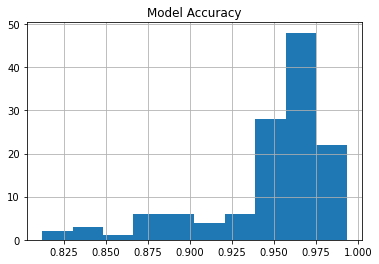

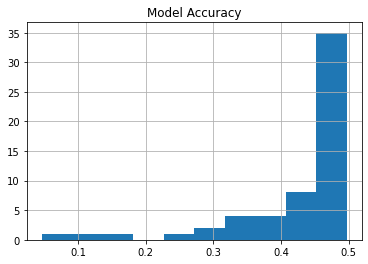

In [5]:
#check out the distribution of high-peformers

df.loc[df['Model Accuracy'] >= 0.8].hist('Model Accuracy')

#check out the distribution of low-performers
df.loc[df['Model Accuracy'] <= 0.5].hist('Model Accuracy')

In [6]:
#finds the proper models to use for experiment

models_high = []
models_low = []
sim_ids = ['2cl2f','2cl8f','2cs2f','2cs8f','3cl2f','3cs2f','3cl8f','3cs8f']
for x in os.listdir('../../data/simulated/simulated_models/'):
    try:
        if x.split('_')[-1][:-3] == sim_ids[3]:
            if int(x.split('_')[1]) in ids_high:
                models_high.append(x)
            elif int(x.split('_')[1]) in ids_low:
                models_low.append(x)
    except:
        pass
print(len(models_high))
print(len(models_low))

126
56


In [7]:
good_models = [load_model('../../data/simulated/simulated_models/{}'.format(x)) for x in models_high]
bad_models = [load_model('../../data/simulated/simulated_models/{}'.format(x)) for x in models_low]

In [8]:
#GENERALIZED STACKING FOR GOOD MODELS

num_layers = []
num_nodes = []
hidden_acts = []
losses = []
accuracies = []


import warnings
warnings.filterwarnings('ignore')

for num_layer in [5]:
    for num_node in [10]:
        for hidden_act in ['relu']:
            for loss in ['categorical_crossentropy']:
                yhat = stacking_pipeline(
                    X_test=X_test, y_test=y_test,
                    models=good_models,
                    num_hidden_layers=num_layer, num_nodes=num_node,
                    hidden_act=hidden_act, 
                    model_loss=loss
                )
                yhat = argmax(yhat, axis=1)
                acc = accuracy_score(y_test, yhat)

                print('Accuracy: {:.6f}'.format(acc))

                num_layers.append(num_layer)
                num_nodes.append(num_node)
                hidden_acts.append(hidden_act)
                losses.append(loss)
                accuracies.append(acc)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.47246 to fit

Accuracy: 1.000000


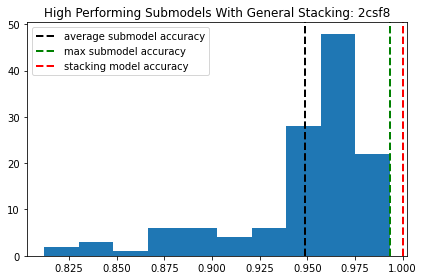

In [19]:
plt.figure()
grab = df.loc[df['Model Accuracy'] >= 0.8]
grab = grab['Model Accuracy']
plt.hist(grab)
plt.axvline(x=np.average(grab), color='k', linestyle='dashed', linewidth=2, label='average submodel accuracy')
plt.axvline(x=np.max(grab), color='g', linestyle='dashed', linewidth=2, label='max submodel accuracy')
plt.axvline(x=1.000000, color='r', linestyle='dashed', linewidth=2, label='stacking model accuracy')
plt.title('High Performing Submodels With General Stacking: 2csf8')
plt.legend()
plt.tight_layout()
plt.savefig('../../results/2csf8_exp3_1')

In [10]:
#GENERALIZED STACKING FOR BAD MODELS

num_layers = []
num_nodes = []
hidden_acts = []
losses = []
accuracies = []


import warnings
warnings.filterwarnings('ignore')

for num_layer in [5]:
    for num_node in [10]:
        for hidden_act in ['relu']:
            for loss in ['categorical_crossentropy']:
                yhat = stacking_pipeline(
                    X_test=X_test, y_test=y_test,
                    models=bad_models,
                    num_hidden_layers=num_layer, num_nodes=num_node,
                    hidden_act=hidden_act, 
                    model_loss=loss
                )
                yhat = argmax(yhat, axis=1)
                acc = accuracy_score(y_test, yhat)

                print('Accuracy: {:.6f}'.format(acc))

                num_layers.append(num_layer)
                num_nodes.append(num_node)
                hidden_acts.append(hidden_act)
                losses.append(loss)
                accuracies.append(acc)

Accuracy: 1.000000


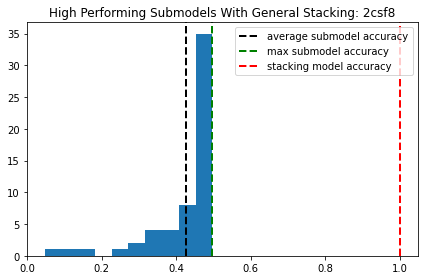

In [20]:
plt.figure()
grab = df.loc[df['Model Accuracy'] <= 0.5]
grab = grab['Model Accuracy']
plt.hist(grab)
plt.axvline(x=np.average(grab), color='k', linestyle='dashed', linewidth=2, label='average submodel accuracy')
plt.axvline(x=np.max(grab), color='g', linestyle='dashed', linewidth=2, label='max submodel accuracy')
plt.axvline(x=1.000000, color='r', linestyle='dashed', linewidth=2, label='stacking model accuracy')
plt.title('High Performing Submodels With General Stacking: 2csf8')
plt.legend()
plt.tight_layout()
plt.savefig('../../results/2csf8_exp3_2')

In [9]:
#compare parameters of the SUB-MODELS

hidden_acts = []
losses = []
num_layers = []
layer_size = []

sim_ids = ['2cl2f','2cl8f','2cs2f','2cs8f','3cl2f','3cs2f','3cl8f','3cs8f']
for x in os.listdir('../../data/simulated/simulated_models/'):
    if x.split('_')[-1][:-3] == sim_ids[3]:
        if int(x.split('_')[1]) in ids_high:
            act = x.split('_')[2]
            hidden_acts.append(act)
            if x.split('_')[3] == 'categorical':
                losses.append('categorical')
            elif x.split('_')[3] == 'poisson':
                losses.append('poisson')
            n_l = int(x.split('_')[-3])
            num_layers.append(n_l)
            s_l = int(x.split('_')[-2])
            layer_size.append(s_l)


good_acc = (df.loc[df['Model Accuracy'] >= 0.8]['Model Accuracy'])
good_loss = (df.loc[df['Model Accuracy'] >= 0.8]['Model Loss'])


df_act_comp = pd.DataFrame(ids_high)
df_act_comp['hidden acts'] = hidden_acts
df_act_comp['loss func'] = losses
df_act_comp['# of layers'] = num_layers
df_act_comp['layer size'] = layer_size
df_act_comp['Loss'] = good_loss
df_act_comp['Accuracy'] = good_acc
del df_act_comp['Model ID']
df_act_comp.head()

,hidden acts,loss func,# of layers,layer size,Loss,Accuracy
21,tanh,poisson,5,10,6.160480e-08,0.872483
45,relu,poisson,10,25,6.160480e-08,0.832215
64,sigmoid,poisson,3,10,6.257846e-01,0.953020
65,relu,poisson,5,15,6.178256e-01,0.879195
66,relu,poisson,10,5,6.379456e-01,0.932886


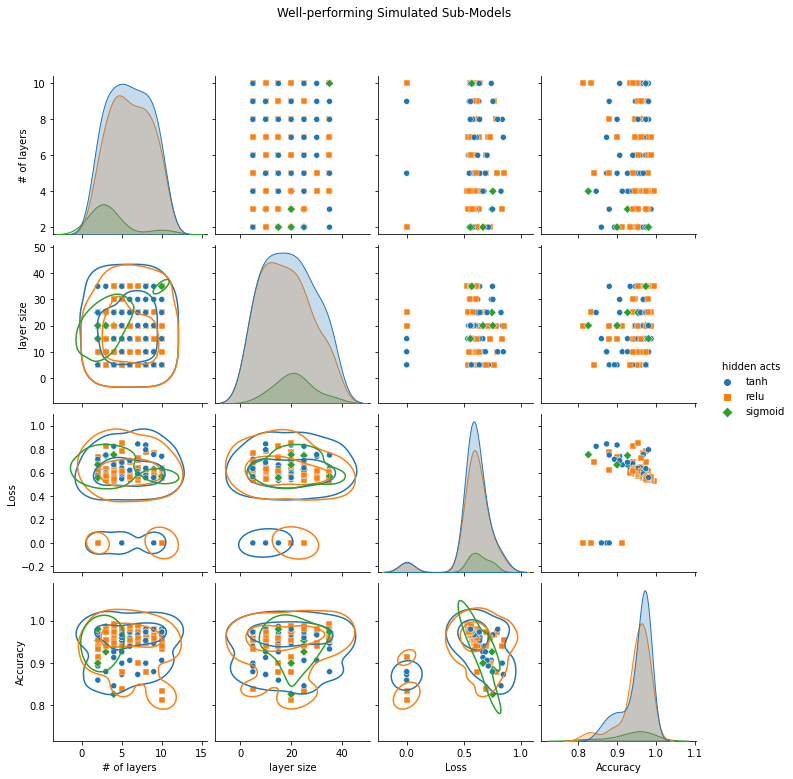

In [81]:
import seaborn as sns
g = sns.pairplot(df_act_comp, hue="hidden acts", markers=["o", "s", "D"])
g.map_lower(sns.kdeplot, levels=3, color=".2")
g.fig.suptitle("Well-performing Simulated Sub-Models", y=1.08)
plt.savefig('../../results/2csf8_submodels_1')


Highest accuracy --> Tanh.
Very little correlation between layer size and the number of layers, with the accuracy


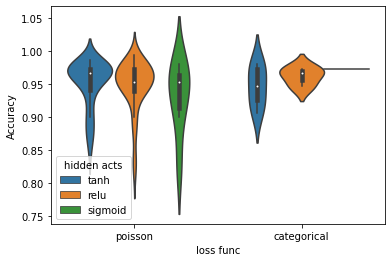

In [88]:
sns.violinplot(data=df_act_comp, x="loss func", y="Accuracy", hue="hidden acts")
plt.savefig('../../results/2csf8_submodels_2')

poisson has a larger distribution of accuracy than categorical

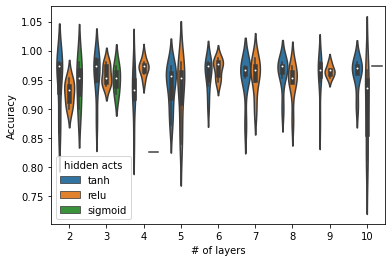

In [89]:
sns.violinplot(data=df_act_comp, x="# of layers", y="Accuracy", hue="hidden acts")
plt.savefig('../../results/2csf8_submodels_3')

It seems like the optimal number of layers is 6

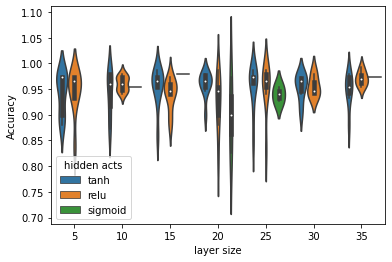

In [90]:
sns.violinplot(data=df_act_comp, x="layer size", y="Accuracy", hue="hidden acts")
plt.savefig('../../results/2csf8_submodels_4')

Layer size doesn't seem to vary a whole lot, except that layers that are size 20 have a much larger distribution.

In [12]:
###############-------------##############
#what happens when we combine different sets of parameters in the submodels for the stacking model?
#Let's use this same set of submodels, and check out different stacking models. The question this is answering is that: does creating a good stacking model function similarly to creating a good submodel? Are the optimized parameters similar?


num_layers = []
num_nodes = []
hidden_acts = []
losses = []
accuracies = []


import warnings
warnings.filterwarnings('ignore')

for num_layer in [2,5,10]:
    for num_node in [2,5,10]:
        for hidden_act in ['relu', 'sigmoid', 'tanh']:
            for loss in ['categorical_crossentropy', 'poisson', 'binary_crossentropy']:
                yhat = stacking_pipeline(
                    X_test=X_test, y_test=y_test,
                    models=good_models,
                    num_hidden_layers=num_layer, num_nodes=num_node,
                    hidden_act=hidden_act, 
                    model_loss=loss
                )
                yhat = argmax(yhat, axis=1)
                acc = accuracy_score(y_test, yhat)

                print('Accuracy: {:.6f}'.format(acc))

                num_layers.append(num_layer)
                num_nodes.append(num_node)
                hidden_acts.append(hidden_act)
                losses.append(loss)
                accuracies.append(acc)


e number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
Accuracy: 0.551020
Accuracy: 0.551020
Accuracy: 0.551020
Accuracy: 0.551020
Accuracy: 0.551020
Accuracy: 1.000000
Accuracy: 1.000000
Accuracy: 1.000000
Accuracy: 1.000000
Accuracy: 1.000000
Accuracy: 0.551020
Accuracy: 1.000000
Accuracy: 0.551020
Accuracy: 1.000000
Accuracy: 1.000000
Accuracy: 1.000000
Accuracy: 1.000000
Accuracy: 1.000000
Accuracy: 1.000000
Accuracy: 1.000000
Accuracy: 1.000000
Accuracy: 1.000000
Accuracy: 1.000000
Accurac

In [13]:
dicty = {
    "Layers": num_layers,
    "Nodes": num_nodes,
    "Hidden Activation": hidden_acts,
    "Model Loss": losses,
    "Accuracy": accuracies
}

dfy = pd.DataFrame(dicty)
dfy.to_csv('stacking_params_exp3.csv')

Text(0.5, 1.08, 'Stacking on well=performing sub-models')

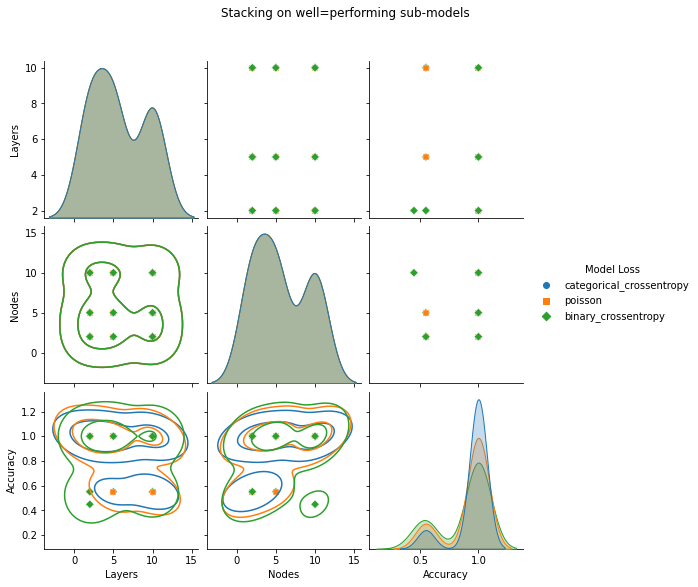

In [15]:
#Let's look at the stacking models
p = sns.pairplot(dfy, hue="Model Loss", markers=["o", "s", "D"])
p.map_lower(sns.kdeplot, levels=3, color=".2")
p.fig.suptitle("Stacking on well=performing sub-models", y=1.08)


In [ ]:
#show densities for accuracies over both submodel experiments, and both stacking model experiments

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
sns.kdeplot(ax=axes[0, 0],data=dfy, x="Accuracy", hue="Hidden Activation", fill=True)
axes[0,0].set_title('Hidden Activation impact')
#axes[0,0].hlines(max(dfy['Accuracy']))
#axes[0,0].axvline(0.9932885766029358, color='black',linestyle='--')
#axes[0,0].axvspan(.8, 1.4, alpha=0.1, color='red')
axes[0,0].set_xlim(0,1.01)


sns.kdeplot(ax=axes[0, 1],data=dfy, x="Accuracy", hue="Model Loss",fill=True)
axes[0,1].set_title('Loss Function impact')
#axes[0,1].axvline(0.9932885766029358, color='black',linestyle='--')
#axes[0,1].axvspan(.8, 1.4, alpha=0.1, color='red')
axes[0,1].set_xlim(0,1.01)


sns.kdeplot(ax=axes[1, 0],data=dfy, x="Accuracy", hue="Layers",fill=True)
axes[1,0].set_title('Layers impact')
#axes[1,0].axvline(0.9932885766029358, color='black',linestyle='--')
#axes[1,0].axvspan(.8, 1.4, alpha=0.1, color='red')
axes[1,0].set_xlim(0,1.01)


sns.kdeplot(ax=axes[1, 1],data=dfy, x="Accuracy", hue="Nodes",fill=True)
axes[1,1].set_title('Nodes impact')
#axes[1,1].axvline(0.9932885766029358, color='black',linestyle='--')
#axes[1,1].axvspan(.8, 1.4, alpha=0.1, color='red')
axes[1,1].set_xlim(0,1.01)

fig.suptitle('Stacking on 9 Poor and 1 Well-Performing Submodels')

plt.savefig('../../results/exp5_mixed_stacking')